# DD2412 Final Project - Basic Implementation CIFAR 100


In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd drive/MyDrive/Github/AdvanceDL_Poject_Group9/
except:
    print("Unable to connect to google drive")

Unable to connect to google drive


In [3]:
# Import general packages
import os
import time
import random
import copy
import scipy as scp
import sklearn as skl
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
import sklearn.metrics

# Variables
%matplotlib inline

In [4]:
# Tensorflow versions
import tensorflow as tf

# Handle not pre-installed packages 
try: 
    import tensorflow_addons as tfa
except:
    os.system("pip install tensorflow-addons")
    import tensorflow_addons as tfa

try: 
    import optuna
except:
    os.system("pip install optuna")
    import optuna

# Print TensorFlow versions
print("TensorFlow version:", tf.__version__)
print("TensorFlow Addon version:", tfa.__version__)

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D
from tensorflow.keras.activations import softmax
from tensorflow.keras import Model

from tensorflow.math import log as tf_log
from tensorflow.math import reduce_sum as tf_sum
from tensorflow.math import scalar_mul as tf_smul

from tensorflow.linalg import normalize as tf_norm

TensorFlow version: 2.8.3
TensorFlow Addon version: 0.18.0


## Setup

### Classes

In [5]:
class DataRecorder():
    """
    Class for keeping track of loss and accuracy during training.
    """
    def __init__(self, df:pd.DataFrame = None):
        self.reset(df)
    
    def reset(self, df:pd.DataFrame = None):
        """Function for reseting recorder."""
        if df is not None:
            self.record = df
        else:
            self.record = pd.DataFrame({
                'set' : pd.Series(dtype='str'),
                'epoch' : pd.Series(dtype='int'),
                'metric' : pd.Series(dtype='str'),
                'value' : pd.Series(dtype='float')
            })

    def record_accuracy(self, set: str, epoch: int, accuracy: float):
        """Records new datapoint for accuracy."""
        self.record = self.record.append({
            'set' : set,
            'epoch' : epoch,
            'metric' : 'accuracy',
            'value' : accuracy
        }, ignore_index=True)
    
    def record_loss(self, set: str, epoch: int, loss: float):
        """Records new datapoint for loss."""
        self.record = self.record.append({
            'set' : set,
            'epoch' : epoch,
            'metric' : 'loss',
            'value' : loss
        }, ignore_index=True)

    def info(self):
        return self.record.info()
    
    def head(self, n:int = 10):
        return self.record.head(n)

    def relplot(self):
        """Plot the loss and accuracy side by side."""
        sns.relplot(data=self.record, x='epoch', y='value', hue='set', 
                    style='set', col='metric', kind='line')
        plt.show()

    def plot(self):
        """Plot the loss and accuracy side by side."""
        f, axs = plt.subplots(1, 2, figsize=(13,6))
        sns.lineplot(
            data=self.record.query("metric == 'loss'"),
            x="epoch", y="value",
            hue="set", style="set", ax=axs[0]).set(title='Loss')
        sns.lineplot(
            data=self.record.query("metric == 'accuracy'"),
            x="epoch", y="value",
            hue="set", style="set", ax=axs[1]).set(title='Accuracy')
        plt.show()

In [6]:
class WarmUpCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, start_lr, target_lr, warmup_steps, total_steps, hold):
        super().__init__()
        self.start_lr = start_lr
        self.target_lr = target_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.hold = hold

    def __call__(self, step):
        lr = self.lr_warmup_cosine_decay(
            global_step=step,total_steps=self.total_steps,
            warmup_steps=self.warmup_steps, start_lr=self.start_lr,
            target_lr=self.target_lr, hold=self.hold)
        return tf.where(
            step > self.total_steps, 0.0, lr, name="learning_rate")
        
    def lr_warmup_cosine_decay(self, global_step, warmup_steps, hold = 0,
                                total_steps=0, start_lr=0.0, target_lr=1e-3):
        learning_rate = 0.5 * target_lr * (1 + tf.cos(tf.constant(np.pi) * (
            global_step - warmup_steps - hold) / float(
                total_steps - warmup_steps - hold)))
        warmup_lr = target_lr * (global_step / warmup_steps)

        if hold > 0:
            learning_rate = tf.where(global_step > warmup_steps + hold,
                                    learning_rate, target_lr)
        learning_rate = tf.where(global_step < warmup_steps,
                                 warmup_lr, learning_rate)
        return learning_rate


### Functions

In [7]:
def check_prediction(model, x, y, aug=None, rows = 2, plot=True):
        # Get random samples from test set
        samples = np.random.randint(x.shape[0], size=rows*3)
        test_image, test_label = x[samples], y[samples]
        # Performe augmentation
        if aug is not None:
            aug_image = aug(test_image)
        else:
            aug_image = test_image
        # Predict class of image
        prediction = model.prediction(aug_image)
        if plot:
            plt.figure(figsize=(13, 5*rows))
            for i in range(aug_image.shape[0]):
                plt.subplot(rows, 3, (i+1))
                imgplot = plt.imshow(aug_image[i,:,:,0])
                plt.title(f"GT={test_label[i]}, Prediction={prediction[i]}")

def check_augmentation(x, aug, rows = 2):
        # Get random samples from test set
        samples = np.random.randint(x.shape[0], size=rows*3)
        test_image = x[samples]
        aug_test = aug(test_image)

        plt.figure(figsize=(13, 5*rows))
        for i in range(aug_test.shape[0]):
            plt.subplot(rows, 3, (i+1))
            imgplot = plt.imshow(aug_test[i,:,:,0])

In [8]:
def lr_schedular(schedule: str = None, batch_count: int = 0):
    """Returns a schedular object depending on string input"""
    if schedule == "WarmUpCosineDecay":
        total_steps = batch_count*config['EPOCHS']
        warmup_steps = int(0.05*total_steps)

        return WarmUpCosineDecay(start_lr=0.0, target_lr=config['MAX_LR'], 
                                 warmup_steps=warmup_steps, 
                                 total_steps=total_steps, 
                                 hold=warmup_steps)
    else:
        return


In [9]:
class SelfClassifier():
    def __init__(self, n_batch: int, n_class: int, t_r: float, t_c: float):
        self.N = n_batch
        self.C = n_class
        self.t_r = t_r
        self.t_c = t_c

    def __call__(self, s1, s2):
        N, C, t_r, t_c = self.N, self.C, self.t_r, self.t_c
        # log_y_x1
        softmax_y_x1 = softmax(s1/t_r, axis=1)
        norm_y_x1, _ = tf_norm(softmax_y_x1, ord=1, axis=0)
        log_y_x1 = tf_log(N/C * norm_y_x1)

        # log_y_x2
        softmax_y_x2 = softmax(s2/t_r, axis=1)
        norm_y_x2, _ = tf_norm(softmax_y_x2, ord=1, axis=0)
        log_y_x2 = tf_log(N/C * norm_y_x2)

        y_x1, _ = tf_norm(softmax(s1/t_c, axis=0), ord=1, axis=1)
        y_x2, _ = tf_norm(softmax(s2/t_c, axis=0), ord=1, axis=1)

        l1 = - tf_sum(y_x2*log_y_x1, axis=-1) / N
        l2 = - tf_sum(y_x1 * log_y_x2, axis=-1) / N
        L = tf_sum((l1 + l2) / 2)
        return L
        

## Config

In [10]:
# Create config variable
config = {
    # Data Parameters
    'IMAGE_SIZE' : 28, 
    'BATCH_SIZE' : 64,
    'CLASS_COUNT' : 10,
    'N_AUG' : 3,
    # Training parameters
    'LR_SCHED' : "WarmUpCosineDecay",
    'OPTIM' : tf.keras.optimizers.Adam(),
    'EPOCHS' : 30,
    'MAX_LR' : 0.005,
}
# setup for plottning
sns.set_theme(style="darkgrid")
sns_pal = "dark"

## Data Loading

In [11]:
# Download MNIST dataset
dataset = tf.keras.datasets.cifar100  
# Split into train and test data
(x_train, y_train), (x_test, y_test) = dataset.load_data()

In [12]:
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


## Image Augmentation

In [13]:
aug_seq = iaa.Sequential([
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order

In [14]:
# Generate a number of augmentations of each train image
def gen_augment(images, n_augments=1, normalize=None):

    augments = []
    for i in range(n_augments):
        # Generate augmentation
        augment = aug_seq(images=images)

        # Normalize dataset
        if normalize is not None:
            augment = augment / normalize

        # Store augmentation
        augments.append(augment)
        print(f'Augment {i+1} complete')
    
    return augments 

In [15]:
# Gets n ramdom augments from a list of augmentations
def rand_augment(aug_list, n_augments):
    return random.choices(aug_list, k=n_augments)

In [16]:
aug_x_train = gen_augment(x_train, n_augments=config['N_AUG'])

Augment 1 complete
Augment 2 complete
Augment 3 complete


In [17]:
aug_x_test = gen_augment(x_test, n_augments=config['N_AUG'])

Augment 1 complete
Augment 2 complete
Augment 3 complete


In [18]:
# Create training dataset
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, *aug_x_train)).shuffle(x_train.shape[0]).batch(config['BATCH_SIZE'])
# Create test dataset
test_ds = tf.data.Dataset.from_tensor_slices(
    (x_test, *aug_x_test, y_test)).batch(config['BATCH_SIZE'])
# Assert Dataset datatype
assert isinstance(train_ds, tf.data.Dataset)
assert isinstance(test_ds, tf.data.Dataset)

## Create a Model

In [19]:
class DynamicModel(Model):
    def __init__(self, input_shape, n_layers=2, n_nodes=128, 
                 activation=tf.keras.layers.ReLU(), batch_norm=True):
        super(DynamicModel, self).__init__()
        # Input layers
        self.model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(16, 3, activation=activation, 
                                   input_shape=input_shape),
            tf.keras.layers.Flatten()
        ])
        # Hidden Layers 
        for i in range(n_layers):
            self.model.add(tf.keras.layers.Dense(n_nodes))
            self.model.add(activation)
            if batch_norm:
                self.model.add(tf.keras.layers.BatchNormalization())

        # Output layer
        self.model.add(tf.keras.layers.Dense(config['CLASS_COUNT']))
        self.model.add(tf.keras.layers.Activation("softmax"))

    def call(self, x):
        return self.model(x)

    def reset(self):
        tf.keras.backend.clear_session()

    def prediction(self, x):
        # Function that takes softmax and argmax of the predictions 
        predictions = self.model(x)
        pred_softmax = softmax(predictions, axis=0)
        top_class = tf.argmax(pred_softmax, axis=1)
        return top_class

    def to_prediction(self, predictions):
        # Function that takes softmax and argmax of the predictions 
        #pred_softmax = softmax(predictions, axis=0)
        top_class = tf.argmax(predictions, axis=1)
        return top_class
 

In [20]:
check_model = DynamicModel(x_test.shape[1:])
print(check_model.model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 flatten (Flatten)           (None, 14400)             0         
                                                                 
 dense (Dense)               (None, 128)               1843328   
                                                                 
 re_lu (ReLU)                (None, 128)               0         
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                        

## Train Network

In [21]:
class UnderSupervisedLearner():
    def __init__(self, model, optimizer, loss_object_train, loss_object_test, 
                 data_augmentation, recorder: DataRecorder=None):
        # Set optimizer and loss function
        self.model = model
        self.optimizer = optimizer
        self.loss_object_train = loss_object_train
        self.loss_object_test = loss_object_test
        self.data_augmentation = data_augmentation
        self.recorder = recorder
        
        # Keeps track of training loss and accuracy 
        self.train_loss = tf.keras.metrics.Mean(name='train_loss')

        # Keeps track of test loss and accuracy 
        self.test_loss = tf.keras.metrics.Mean(name='test_loss')
        self.test_acc = tf.keras.metrics.SparseCategoricalAccuracy(
            name='test_accuracy')
        
        # Validation trackig 
        self.valid_loss = []
        self.valid_nmi = []
        self.valid_ami = []
        self.valid_ari = []
        self.valid_acc = []

    def reset(self):
        for var in self.optimizer.variables():
            var.assign(tf.zeros_like(var))

    #@tf.function
    def train_step(self, a1, a2):

        with tf.GradientTape() as tape:
            s1 = self.model(a1, training=True)
            s2 = self.model(a2, training=True)
            loss = loss = self.loss_object_train(s1, s2)
        
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(gradients, self.model.trainable_variables))

        self.train_loss(loss)
        return
    
    def valid_step(self, a1, a2, gt):
        s1 = self.model(a1)
        s2 = self.model(a2)
        loss = self.loss_object_train(s1, s2)
        self.valid_loss.append(loss)

        p1 = self.model.to_prediction(s1)
        p2 = self.model.to_prediction(s2)
        self.valid_nmi.append(skl.metrics.normalized_mutual_info_score(p1, p2))
        self.valid_ami.append(skl.metrics.adjusted_mutual_info_score(p1, p2))
        self.valid_ari.append(skl.metrics.adjusted_rand_score(p1, p2))
        self.valid_acc.append(skl.metrics.accuracy_score(p1, p2))
        return


    @tf.function
    def test_step(self, images, labels):
        predictions = self.model(images, training=False)
        t_loss = self.loss_object_test(labels, predictions)

        self.test_loss(t_loss)
        self.test_acc(labels, predictions)
        

        
    def fit(self, plot_every=0, early_stopping=False, patience=3, wait_epoch=1):
        """Training function to fit the network"""
        all_time = time.time()
        saved_loss = None
        saved_acc = None
        count = patience
        
        for epoch in range(config['EPOCHS']):
            epoch_time = time.time()
            # Reset the metrics at the start of the next epoch
            self.train_loss.reset_states()
            self.test_loss.reset_states()
            self.test_acc.reset_states()
            self.valid_loss = []
            self.valid_nmi = []
            self.valid_ami = []
            self.valid_ari = []
            self.valid_acc = []

            print(30*"=", "EPOCH",(epoch+1), 30*"=")

            # Training loop
            for image, *augments in tqdm(train_ds, "Training"):
                a1, a2 = rand_augment(augments, 2)
                self.train_step(a1, a2)

            # Validation loop
            for image, *augments, test_labels in tqdm(test_ds, "Validation"):
                a1, a2 = rand_augment(augments, 2)
                labels = test_labels.numpy()
                self.valid_step(a1, a2, labels)


            epoch_lr = self.optimizer._decayed_lr(tf.float32).numpy()
            # Print information about epoch
            print(f'Epoch {epoch + 1}, '
                f'Learning Rate: {epoch_lr:.5f}, '
                f'Epoch time: {time.time()-epoch_time:.2f} seconds')
            
            print(f'Loss: {self.train_loss.result():.3f}, '
                  f'Valid Loss: {np.mean(self.valid_loss):.4f}, '
                  f'NMI: {np.mean(self.valid_nmi):.4f}, '
                  f'AMI: {np.mean(self.valid_ami):.4f}, '
                  f'ARI: {np.mean(self.valid_ari):.4f}, '
                  f'ACC: {np.mean(self.valid_acc):.4f}, '                
                )

            # record data
            if (self.recorder is not None):
                self.recorder.record_loss(
                    'train', (epoch+1),self.train_loss.result().numpy())
                self.recorder.record_loss(
                    'validation', (epoch+1), np.mean(self.valid_loss))
                self.recorder.record_accuracy(
                    'validation', (epoch+1), np.mean(self.valid_acc))
            if plot_every != 0 and (epoch + 1) % plot_every == 0:
                # Plot resutls so far
                self.recorder.plot()
        

            if epoch > wait_epoch:
                if saved_loss is None: 
                    saved_loss = np.mean(self.valid_loss)
                    saved_acc = np.mean(self.valid_acc)
                    count = patience
                elif np.mean(self.valid_loss) < saved_loss:
                    saved_loss = np.mean(self.valid_loss) 
                    saved_acc = np.mean(self.valid_acc)
                    count = patience
                elif count > 0:
                    count -= 1
                elif count  == 0:
                    print(f'Out of patience! Returning {saved_acc:.4f}')
                    return saved_loss, saved_acc
                
        print("")
        print(26*"<", 
              f'FINISHED {(time.time()-all_time):.2f}s', 
              26*">") 
        
        return np.mean(self.valid_loss), np.mean(self.valid_acc)


In [24]:
def test_run():
    # Create a data recorder and fit the data
    recorder = DataRecorder()

    # Instansiate loss function
    loss_object_test = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    # Instansiate SelfClassifier loss function
    loss_object_train = SelfClassifier(n_batch=config['BATCH_SIZE'], 
                        n_class=config['CLASS_COUNT'], t_r=0.1, t_c=0.05)
    # Instansiate optimizer 
    optimizer = copy.deepcopy(config['OPTIM'])
    #optimizer.learning_rate = lr_schedular(config['LR_SCHED'],len(train_ds))
    decay_steps = len(train_ds)*config['EPOCHS']
    print(decay_steps)
    optimizer.learning_rate = tf.keras.optimizers.schedules.CosineDecay(
        config['MAX_LR'], decay_steps, alpha=0.0, name=None
    )
    n_layers = 4
    batch_norm = True
    # Create an instance of the model
    model = DynamicModel(input_shape=x_train.shape[1:],
                         n_layers=n_layers)

    learner = UnderSupervisedLearner(model=model, optimizer=optimizer,
                                 loss_object_train=loss_object_train,
                                 loss_object_test=loss_object_test,
                                 data_augmentation=aug_seq,
                                 recorder=recorder)
    # Train the model
    return learner.fit(plot_every=5, 
                       wait_epoch=int(config['EPOCHS']*0.1))


23460
============================== EPOCH 1 ==============================


Validation: 100%|██████████| 157/157 [00:04<00:00, 38.22it/s]
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({


Epoch 1, Learning Rate: 0.00499, Epoch time: 61.96 seconds
Loss: 1.428, Valid Loss: 1.3414, NMI: 0.7016, AMI: 0.5796, ARI: 0.5408, ACC: 0.6987, 
============================== EPOCH 2 ==============================


Validation: 100%|██████████| 157/157 [00:03<00:00, 40.56it/s]
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({


Epoch 2, Learning Rate: 0.00495, Epoch time: 61.91 seconds
Loss: 1.219, Valid Loss: 1.5150, NMI: 0.7053, AMI: 0.5916, ARI: 0.6158, ACC: 0.7157, 
============================== EPOCH 3 ==============================


Validation: 100%|██████████| 157/157 [00:03<00:00, 41.48it/s]
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({


Epoch 3, Learning Rate: 0.00488, Epoch time: 61.75 seconds
Loss: 1.184, Valid Loss: 1.2234, NMI: 0.6994, AMI: 0.5677, ARI: 0.5072, ACC: 0.6866, 
============================== EPOCH 4 ==============================


Validation: 100%|██████████| 157/157 [00:03<00:00, 41.08it/s]
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({


Epoch 4, Learning Rate: 0.00478, Epoch time: 61.30 seconds
Loss: 1.126, Valid Loss: 1.1229, NMI: 0.7227, AMI: 0.6107, ARI: 0.5655, ACC: 0.7339, 
============================== EPOCH 5 ==============================


Validation: 100%|██████████| 157/157 [00:03<00:00, 41.52it/s]
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({


Epoch 5, Learning Rate: 0.00467, Epoch time: 62.16 seconds
Loss: 1.107, Valid Loss: 1.1021, NMI: 0.7261, AMI: 0.6161, ARI: 0.5609, ACC: 0.7372, 


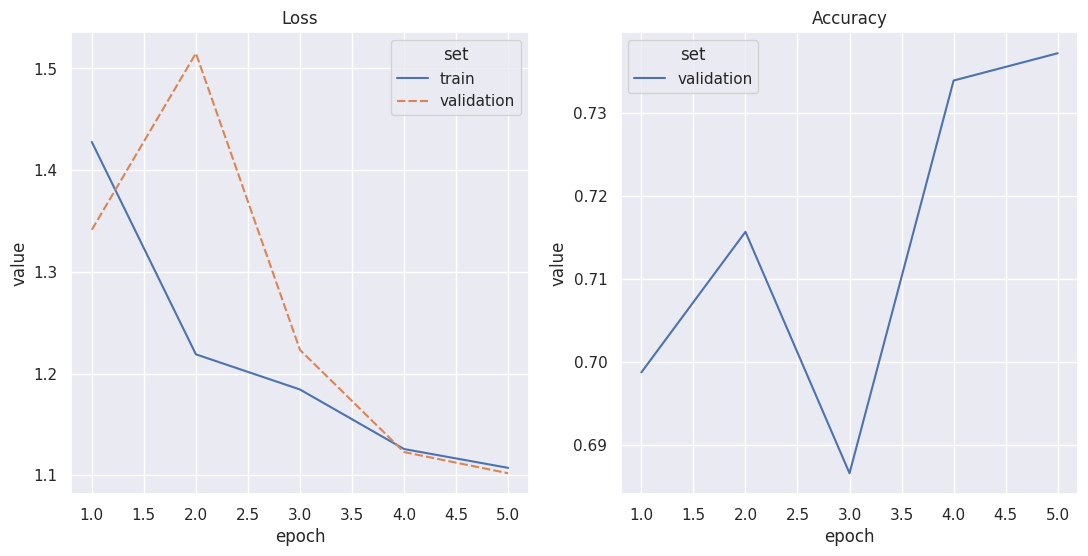

============================== EPOCH 6 ==============================


Validation: 100%|██████████| 157/157 [00:03<00:00, 42.57it/s]
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({


Epoch 6, Learning Rate: 0.00452, Epoch time: 61.48 seconds
Loss: 1.070, Valid Loss: 1.1095, NMI: 0.7448, AMI: 0.6449, ARI: 0.6045, ACC: 0.7625, 
============================== EPOCH 7 ==============================


Validation: 100%|██████████| 157/157 [00:03<00:00, 41.46it/s]
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({


Epoch 7, Learning Rate: 0.00436, Epoch time: 61.39 seconds
Loss: 1.033, Valid Loss: 1.0819, NMI: 0.7407, AMI: 0.6354, ARI: 0.5815, ACC: 0.7466, 
============================== EPOCH 8 ==============================


Validation: 100%|██████████| 157/157 [00:03<00:00, 41.66it/s]
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({


Epoch 8, Learning Rate: 0.00417, Epoch time: 61.79 seconds
Loss: 0.975, Valid Loss: 1.2311, NMI: 0.7106, AMI: 0.6124, ARI: 0.5822, ACC: 0.7578, 
============================== EPOCH 9 ==============================


Validation: 100%|██████████| 157/157 [00:03<00:00, 42.24it/s]
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({


Epoch 9, Learning Rate: 0.00397, Epoch time: 61.25 seconds
Loss: 0.975, Valid Loss: 1.0772, NMI: 0.7176, AMI: 0.5959, ARI: 0.5377, ACC: 0.7248, 
============================== EPOCH 10 ==============================


Validation: 100%|██████████| 157/157 [00:03<00:00, 41.80it/s]
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({


Epoch 10, Learning Rate: 0.00375, Epoch time: 61.01 seconds
Loss: 0.962, Valid Loss: 1.0798, NMI: 0.7457, AMI: 0.6480, ARI: 0.5935, ACC: 0.7649, 


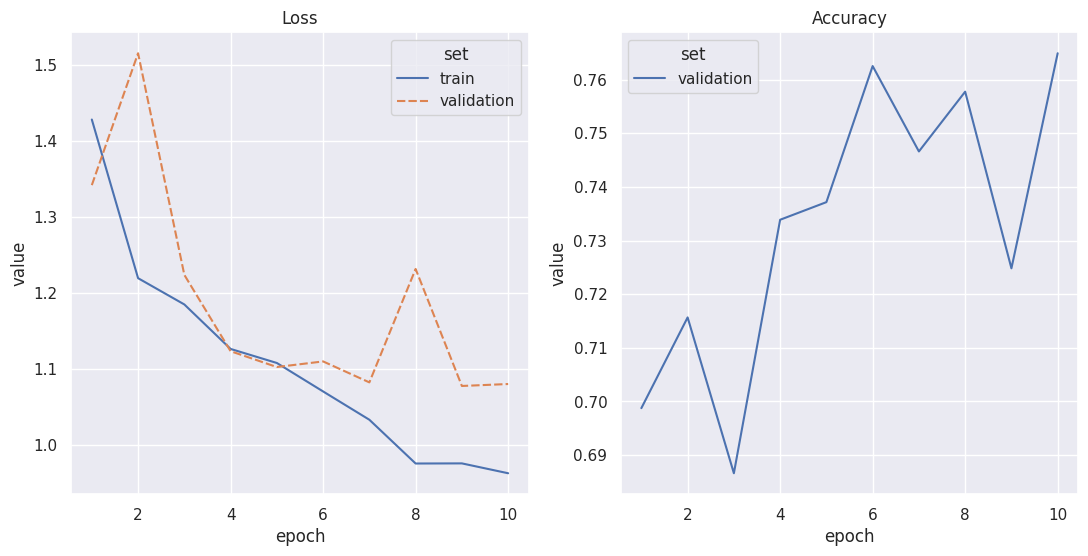

============================== EPOCH 11 ==============================


Validation: 100%|██████████| 157/157 [00:03<00:00, 42.98it/s]
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({


Epoch 11, Learning Rate: 0.00352, Epoch time: 60.81 seconds
Loss: 0.937, Valid Loss: 1.0013, NMI: 0.7404, AMI: 0.6299, ARI: 0.5812, ACC: 0.7518, 
============================== EPOCH 12 ==============================


Validation: 100%|██████████| 157/157 [00:03<00:00, 42.75it/s]
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({


Epoch 12, Learning Rate: 0.00327, Epoch time: 59.36 seconds
Loss: 0.921, Valid Loss: 1.0425, NMI: 0.7535, AMI: 0.6480, ARI: 0.6056, ACC: 0.7635, 
============================== EPOCH 13 ==============================


Validation: 100%|██████████| 157/157 [00:03<00:00, 43.94it/s]
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({


Epoch 13, Learning Rate: 0.00302, Epoch time: 58.93 seconds
Loss: 0.895, Valid Loss: 1.1634, NMI: 0.7599, AMI: 0.6823, ARI: 0.6440, ACC: 0.7965, 
============================== EPOCH 14 ==============================


Validation: 100%|██████████| 157/157 [00:03<00:00, 42.61it/s]
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({


Epoch 14, Learning Rate: 0.00276, Epoch time: 59.55 seconds
Loss: 0.898, Valid Loss: 1.0522, NMI: 0.7533, AMI: 0.6633, ARI: 0.6089, ACC: 0.7808, 
============================== EPOCH 15 ==============================


Validation: 100%|██████████| 157/157 [00:03<00:00, 43.79it/s]
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({


Epoch 15, Learning Rate: 0.00250, Epoch time: 59.88 seconds
Loss: 0.832, Valid Loss: 0.9478, NMI: 0.7472, AMI: 0.6380, ARI: 0.5789, ACC: 0.7628, 


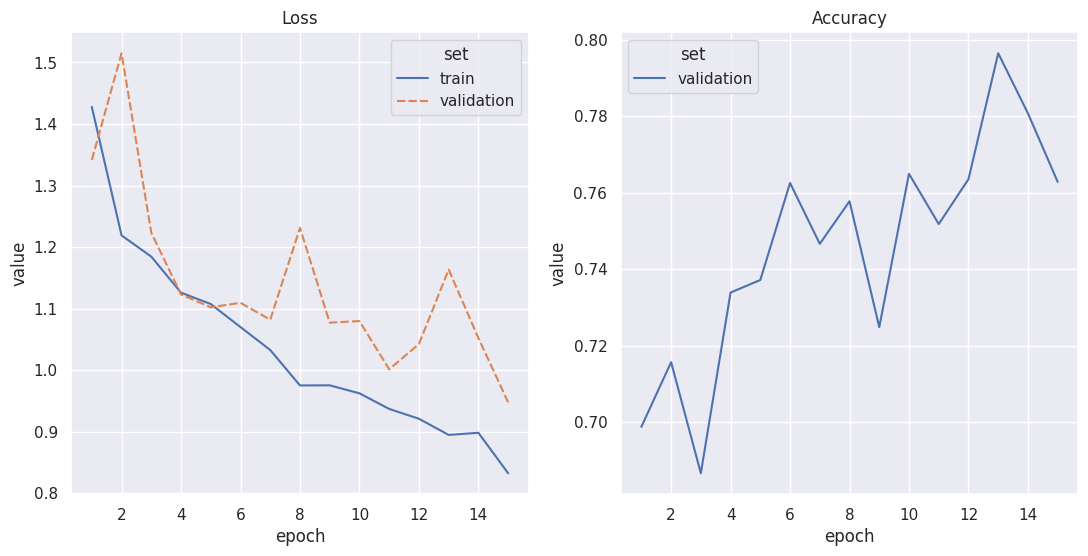

============================== EPOCH 16 ==============================


Validation: 100%|██████████| 157/157 [00:03<00:00, 42.75it/s]
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({


Epoch 16, Learning Rate: 0.00224, Epoch time: 58.33 seconds
Loss: 0.862, Valid Loss: 0.9536, NMI: 0.7461, AMI: 0.6393, ARI: 0.5790, ACC: 0.7620, 
============================== EPOCH 17 ==============================


Validation: 100%|██████████| 157/157 [00:03<00:00, 41.59it/s]
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({


Epoch 17, Learning Rate: 0.00198, Epoch time: 59.95 seconds
Loss: 0.825, Valid Loss: 0.9057, NMI: 0.7783, AMI: 0.6830, ARI: 0.6415, ACC: 0.7926, 
============================== EPOCH 18 ==============================


Validation: 100%|██████████| 157/157 [00:03<00:00, 43.48it/s]
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({


Epoch 18, Learning Rate: 0.00173, Epoch time: 59.59 seconds
Loss: 0.830, Valid Loss: 0.8693, NMI: 0.7638, AMI: 0.6586, ARI: 0.6039, ACC: 0.7787, 
============================== EPOCH 19 ==============================


Validation: 100%|██████████| 157/157 [00:03<00:00, 43.33it/s]
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({


Epoch 19, Learning Rate: 0.00148, Epoch time: 58.81 seconds
Loss: 0.805, Valid Loss: 0.8427, NMI: 0.7749, AMI: 0.6763, ARI: 0.6240, ACC: 0.7904, 
============================== EPOCH 20 ==============================


Validation: 100%|██████████| 157/157 [00:03<00:00, 43.40it/s]
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({


Epoch 20, Learning Rate: 0.00125, Epoch time: 58.04 seconds
Loss: 0.820, Valid Loss: 0.8482, NMI: 0.7776, AMI: 0.6803, ARI: 0.6363, ACC: 0.7937, 


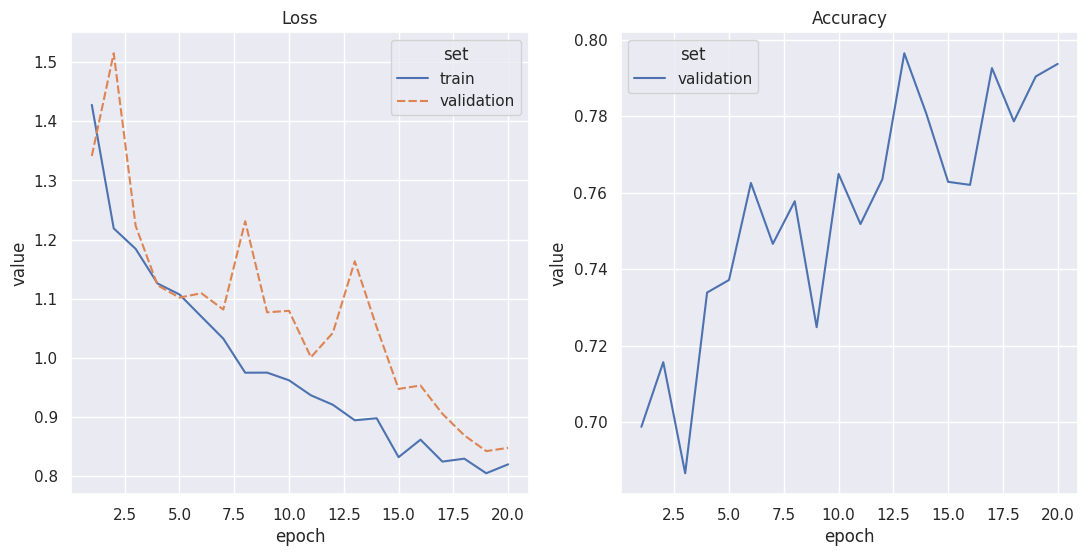

============================== EPOCH 21 ==============================


Validation: 100%|██████████| 157/157 [00:03<00:00, 43.54it/s]
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({


Epoch 21, Learning Rate: 0.00103, Epoch time: 58.90 seconds
Loss: 0.802, Valid Loss: 0.8608, NMI: 0.7618, AMI: 0.6550, ARI: 0.6007, ACC: 0.7763, 
============================== EPOCH 22 ==============================


Validation: 100%|██████████| 157/157 [00:03<00:00, 42.24it/s]
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({


Epoch 22, Learning Rate: 0.00083, Epoch time: 58.56 seconds
Loss: 0.788, Valid Loss: 0.8558, NMI: 0.7582, AMI: 0.6505, ARI: 0.5923, ACC: 0.7768, 
============================== EPOCH 23 ==============================


Validation: 100%|██████████| 157/157 [00:03<00:00, 43.81it/s]
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({


Epoch 23, Learning Rate: 0.00064, Epoch time: 59.30 seconds
Loss: 0.792, Valid Loss: 0.8217, NMI: 0.7750, AMI: 0.6763, ARI: 0.6187, ACC: 0.7929, 
============================== EPOCH 24 ==============================


Validation: 100%|██████████| 157/157 [00:03<00:00, 42.58it/s]
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({


Epoch 24, Learning Rate: 0.00048, Epoch time: 58.56 seconds
Loss: 0.756, Valid Loss: 0.8102, NMI: 0.7758, AMI: 0.6766, ARI: 0.6195, ACC: 0.7925, 
============================== EPOCH 25 ==============================


Validation: 100%|██████████| 157/157 [00:03<00:00, 43.27it/s]
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({


Epoch 25, Learning Rate: 0.00033, Epoch time: 58.54 seconds
Loss: 0.764, Valid Loss: 0.7951, NMI: 0.7887, AMI: 0.6962, ARI: 0.6403, ACC: 0.8075, 


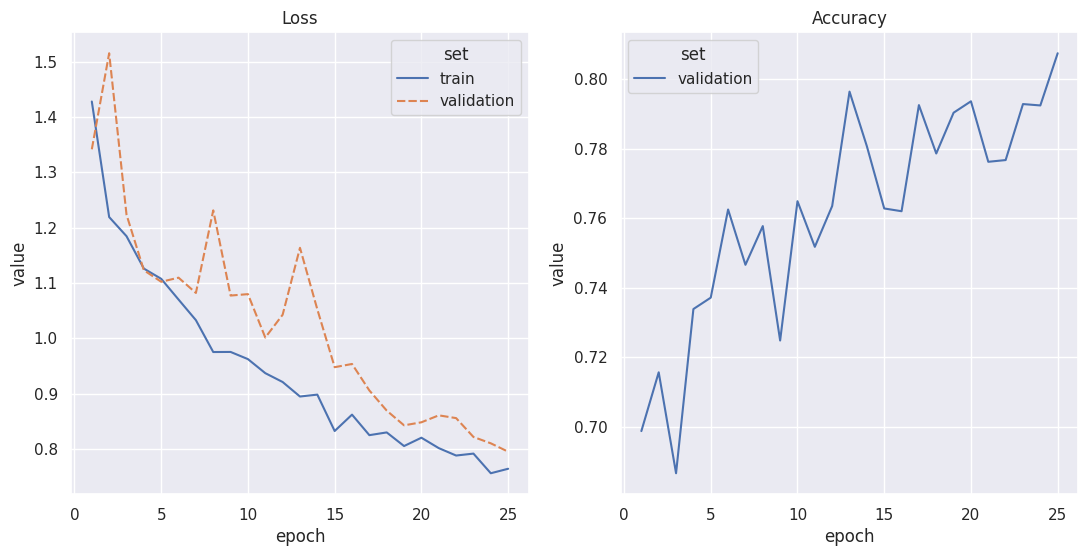

============================== EPOCH 26 ==============================


Validation: 100%|██████████| 157/157 [00:03<00:00, 43.98it/s]
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({


Epoch 26, Learning Rate: 0.00022, Epoch time: 58.41 seconds
Loss: 0.745, Valid Loss: 0.8120, NMI: 0.7764, AMI: 0.6781, ARI: 0.6197, ACC: 0.7918, 
============================== EPOCH 27 ==============================


Validation: 100%|██████████| 157/157 [00:03<00:00, 42.75it/s]
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({


Epoch 27, Learning Rate: 0.00012, Epoch time: 58.35 seconds
Loss: 0.767, Valid Loss: 0.7831, NMI: 0.7845, AMI: 0.6875, ARI: 0.6332, ACC: 0.7996, 
============================== EPOCH 28 ==============================


Validation: 100%|██████████| 157/157 [00:03<00:00, 42.99it/s]
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({


Epoch 28, Learning Rate: 0.00005, Epoch time: 58.59 seconds
Loss: 0.745, Valid Loss: 0.7703, NMI: 0.7917, AMI: 0.6987, ARI: 0.6466, ACC: 0.8106, 
============================== EPOCH 29 ==============================


Validation: 100%|██████████| 157/157 [00:03<00:00, 43.43it/s]
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({


Epoch 29, Learning Rate: 0.00001, Epoch time: 58.67 seconds
Loss: 0.741, Valid Loss: 0.8408, NMI: 0.7581, AMI: 0.6498, ARI: 0.5893, ACC: 0.7784, 
============================== EPOCH 30 ==============================


Validation: 100%|██████████| 157/157 [00:03<00:00, 43.32it/s]
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({
<ipython-input-5-9207ef451179>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.record = self.record.append({


Epoch 30, Learning Rate: 0.00000, Epoch time: 58.42 seconds
Loss: 0.767, Valid Loss: 0.7717, NMI: 0.7945, AMI: 0.7041, ARI: 0.6512, ACC: 0.8128, 


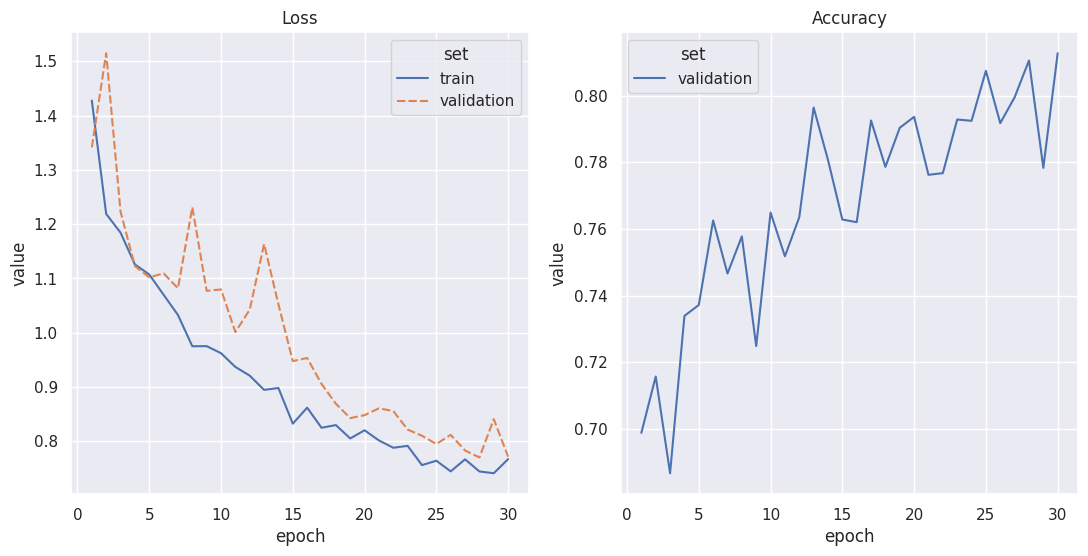


<<<<<<<<<<<<<<<<<<<<<<<<<< FINISHED 1799.08s >>>>>>>>>>>>>>>>>>>>>>>>>>


(0.77166516, 0.8127985668789809)

In [25]:
test_run()

In [24]:
def objective(trial):
    # Create a data recorder and fit the data
    recorder = DataRecorder()

    # Instansiate loss function
    loss_object_test = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    # Instansiate SelfClassifier loss function
    loss_object_train = SelfClassifier(n_batch=config['BATCH_SIZE'], 
                        n_class=config['CLASS_COUNT'], t_r=0.1, t_c=0.05)
    # Instansiate optimizer 
    optimizer = copy.deepcopy(config['OPTIM'])
    optimizer.learning_rate = lr_schedular(config['LR_SCHED'],len(train_ds))

    n_layers = trial.suggest_int('n_layers', 1, 5) 
    batch_norm = trial.suggest_categorical('batch_norm', [True, False])
    # Create an instance of the model
    model = DynamicModel(input_shape=x_train.shape[1:],
                         n_layers=n_layers)

    learner = UnderSupervisedLearner(model=model, optimizer=optimizer,
                                 loss_object_train=loss_object_train,
                                 loss_object_test=loss_object_test,
                                 data_augmentation=aug_seq,
                                 recorder=recorder)
    # Train the model
    return learner.fit(plot_every=5, 
                       wait_epoch=int(config['EPOCHS']*0.1))


In [25]:
import logging
import sys
import optuna

# Add stream handler of stdout to show the messages
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "cifar100-layer_BN-study"  # Unique identifier of the study.
storage_name = "sqlite:///studies/{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, storage=storage_name, 
                            directions=["minimize", "maximize"],
                            load_if_exists=True)

[I 2022-11-29 12:07:09,996] A new study created in RDB with name: cifar100-layer_BN-study


A new study created in RDB with name: cifar100-layer_BN-study


In [26]:
study.optimize(objective, n_trials=20)

Output hidden; open in https://colab.research.google.com to view.

## Plot Final Metrics

In [27]:
print(f"Number of trials: {len(study.trials)}")

trial_with_smallest_loss = min(study.best_trials, key=lambda t: t.values[0])
print(f"Trial with highest accuracy: ")
print(f"\tnumber: {trial_with_smallest_loss.number}")
print(f"\tparams: {trial_with_smallest_loss.params}")
print(f"\tvalues: {trial_with_smallest_loss.values}")
print()

trial_with_highest_accuracy = max(study.best_trials, key=lambda t: t.values[1])
print(f"Trial with highest accuracy: ")
print(f"\tnumber: {trial_with_highest_accuracy.number}")
print(f"\tparams: {trial_with_highest_accuracy.params}")
print(f"\tvalues: {trial_with_highest_accuracy.values}")

Number of trials: 20
Trial with highest accuracy: 
	number: 16
	params: {'n_layers': 4, 'batch_norm': True}
	values: [0.7245240807533264, 0.81220703125]

Trial with highest accuracy: 
	number: 18
	params: {'n_layers': 1, 'batch_norm': True}
	values: [0.9791448712348938, 0.8200310202205883]


In [28]:
optuna.visualization.plot_pareto_front(study, target_names=["Loss", "Accuracy"])

In [29]:
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.values[0], target_name="Loss"
)

In [30]:
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.values[1], target_name="Accuracy"
)